# Predictions of US COVID-19 Pandemic: Comparisons Among Different Models
## Final Report
### Principal Investigators:
Yichen Zhu    (zhu389@wisc.edu) ,
Yuzhou Wang   (wang2555@wisc.edu)

### 1. Questions to be addressed and method used in this project
Reported by WHO, there have been more than 40 million confirmed cases of COVID-19,  including over 1 million deaths globally as of 21 October 2020. While the pandemic in most Asian countries are currently under control, the infection and mortality rate in many countries like US are still unstable. We believe that it is necessary to conduct accurate predictions on the pandemic regionaly and provide instructive suggestions for the US residents and government.

Our main task for this project is to make forecast of future pandemic situations. For the sake of selecting a best model to accomplish this task, we compared different models by its predicting performance. We also segregate our analysis into two parts: forecasting on cumulative confirmed cases and on increase in new confirmed cases. For the first part of our study, time-series models including AR2, MA2, ARIMA(2,2,2) and the VAR2 model were applied to predict the one week cumulative US infection rate. In addition to ARIMA model, Prophet model from Facebook were implemented to forecast on increase in US daily new confirmed cases. As a result, we found Probit algorithm with logistic model and seasonality settings has the strongest predicting power.

## 2. Data
We collected data from the "JHU CSSE COVID-19 Data" which can be access from https://github.com/CSSEGISandData/COVID-19. This time-series data is in a wide structure. Our study can be segregated into two parts. We first implement multiple predicting models with the US cumulative confirmed cases. Then we switch to the data set of daily confirmed cases and work with the daily difference of new confirmed cases in US.

## Coding
**We include all relavant codes necessary for replication of our study on US daily confirmed cases.**

*Note: codes affiliated to the first part of our study (with culumative data) can be found in the R file.

### Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import warnings
import math as m

In [2]:
os.getcwd()

'/Users/ellenyz/OneDrive - UW-Madison/Fall2020/Econ770/GroupProj'

In [3]:
dt = pd.read_csv('data/time_series_covid19_confirmed_US.csv')
dt.sample(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20
106,84004011,US,USA,840,4011.0,Greenlee,Arizona,US,33.214988,-109.240528,...,116,117,120,122,127,128,129,129,132,142
2539,84046015,US,USA,840,46015.0,Brule,South Dakota,US,43.717564,-99.081190,...,392,400,413,431,441,458,467,474,475,487
941,84020035,US,USA,840,20035.0,Cowley,Kansas,US,37.237818,-96.837766,...,793,793,861,861,989,989,989,1104,1104,1198
1077,84021093,US,USA,840,21093.0,Hardin,Kentucky,US,37.697611,-85.963193,...,2679,2752,2839,2880,3009,3120,3204,3257,3342,3405
1677,84030039,US,USA,840,30039.0,Granite,Montana,US,46.406052,-113.441419,...,83,84,86,86,92,95,101,101,103,107


In [4]:
d = dt.loc[:,'1/22/20':] # Take sample from Jan.22 to Nov.18
d.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20
0,0,0,0,0,0,0,0,0,0,0,...,2328,2328,2351,2385,2417,2435,2456,2481,2506,2529
1,0,0,0,0,0,0,0,0,0,0,...,7345,7348,7409,7454,7523,7596,7646,7696,7772,7849
2,0,0,0,0,0,0,0,0,0,0,...,1107,1107,1112,1113,1117,1123,1128,1130,1134,1137
3,0,0,0,0,0,0,0,0,0,0,...,948,948,961,966,973,978,986,993,1004,1008
4,0,0,0,0,0,0,0,0,0,0,...,2378,2378,2400,2429,2488,2518,2549,2574,2594,2648


In [5]:
d = d.transpose()
d = d.sum(axis=1)
d = d.to_list()  # convert d into numerical list

In [6]:
# Create a new data set with all content that we need
data = pd.DataFrame(columns=['ds','confirm'])
date = list(dt.columns[11:])
date = list(pd.to_datetime(date))

In [7]:
# Check whether they have equal length
len(date) == len(d)
# Take a look at the data set
data['ds'] = date
data['confirm'] = d
data = data.set_index('ds')
data['confirm'] = data['confirm']/1000
data.head(3)

,confirm
ds,
2020-01-22,0.001
2020-01-23,0.001
2020-01-24,0.002


In [8]:
data = data.diff()
data = data.loc['2020-01-23':'2020-11-18',] # set start as 23rd because of diff

In [9]:
data.to_csv('data/covid19_confirmed_US_YZ.csv')

## 3. Time-series Models
### ARMA MODEL

In [10]:
#pip install statsmodels

In [11]:
#pip install pmdarima

In [12]:
#pip install sklearn

In [13]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
# set train and test data set
startdate = '2020-10-18'
train = data.loc[data.index < pd.to_datetime(startdate)]
test  = data.loc[data.index >= pd.to_datetime(startdate)]

In [15]:
model = pm.auto_arima(train, start_p=2, start_q=2,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=5, max_q=5,  # maximum p and q
                      m=1,               # frequency of series
                      d=None,            # automatically find 'd'
                      seasonal=False,    # Without Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model.summary())

# We find optimal model is ARIMA(5,1,5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1595.975, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1597.970, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1597.968, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1594.515, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1583.237, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1568.376, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1595.001, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1551.876, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1578.658, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1534.821, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1548.798, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1513.591, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1511.705, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0]             : 

In [16]:
warnings.filterwarnings('ignore')
model = SARIMAX(train, order = (5,1,5))

In [17]:
result = model.fit(disp=True)

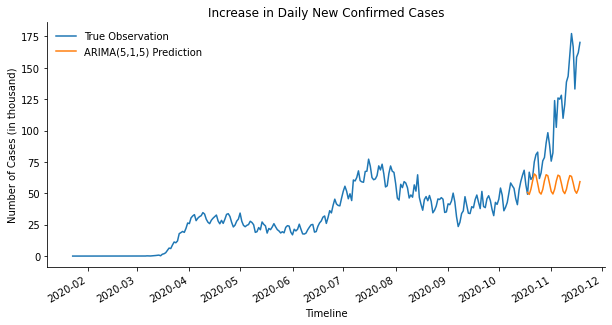

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sarimax_pred = result.predict(
    start = startdate, 
    end = '2020-11-18', 
    dynamic = False)
ax.plot(data, label = 'True Observation')
ax.plot(sarimax_pred, label = 'ARIMA(5,1,5) Prediction')

ax.set_xlabel('Timeline')
ax.set_ylabel('Number of Cases (in thousand)')
ax.set_title('Increase in Daily New Confirmed Cases')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False)

fig.autofmt_xdate()

plt.savefig('SARIMAX prediction.svg',bbox_inches = 'tight', transparent = False)

In [19]:
print('SARIMAX MSE = ', mean_squared_error(sarimax_pred, test))

SARIMAX MSE =  3921.003594974535


In [20]:
print('SARIMAX RMSE = ', m.sqrt(mean_squared_error(sarimax_pred, test)))

SARIMAX RMSE =  62.61791752345758


In [21]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_pred, test))

SARIMAX MAE =  50.925985088530894


### Facebook Prophet
According to intro of facebook open source which can be accesss from https://facebook.github.io/prophet/, "Prophet works best with time series that have strong seasonal effects and several seasons of historical data. It is robust to missing data and shifts in the trend, and typically handles outliers well."

**Reference**
Taylor SJ, Letham B. 2017. Forecasting at scale. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2

In [22]:
pip install Pystan

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install fbprophet

Note: you may need to restart the kernel to use updated packages.


In [24]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [25]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [26]:
train.rename(columns={'confirm':'y'}, inplace = True)
test.rename(columns={'confirm':'y'}, inplace = True)

In [27]:
m = Prophet()
m.fit(train)
  # Might consider weekly cycle here

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
prediction = m.make_future_dataframe(periods=data.shape[0]-train.shape[0])
prophet_prediction = m.predict(prediction)

In [29]:
prophet_prediction.sample(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
56,2020-03-19,11.223022,2.713603,26.239445,11.223022,11.223022,2.834656,2.834656,2.834656,2.834656,2.834656,2.834656,0.0,0.0,0.0,14.057678
86,2020-04-18,20.303496,8.347832,34.022339,20.303496,20.303496,0.696616,0.696616,0.696616,0.696616,0.696616,0.696616,0.0,0.0,0.0,21.000112
235,2020-09-14,47.571071,31.052725,55.594476,47.571071,47.571071,-3.856063,-3.856063,-3.856063,-3.856063,-3.856063,-3.856063,0.0,0.0,0.0,43.715008
237,2020-09-16,47.531244,35.267645,59.536065,47.531244,47.531244,0.513710,0.513710,0.513710,0.513710,0.513710,0.513710,0.0,0.0,0.0,48.044954
283,2020-11-01,46.615223,30.268147,54.928895,46.450781,46.810426,-3.737084,-3.737084,-3.737084,-3.737084,-3.737084,-3.737084,0.0,0.0,0.0,42.878139


In [30]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_fit = prophet_prediction.yhat.loc[prophet_prediction.index>=startdate]
test.set_index('ds',inplace=True)
print('Prophet MAE = ', mean_absolute_error(prophet_fit, test))

Prophet MAE =  61.21309033842178


In [31]:
print('Prophet MSE = ', mean_squared_error(prophet_fit, test))

Prophet MSE =  5110.885062996438


In [32]:
import math as m
print('Prophet RMSE = ', m.sqrt(mean_squared_error(prophet_fit, test)))

Prophet RMSE =  71.49045434879008


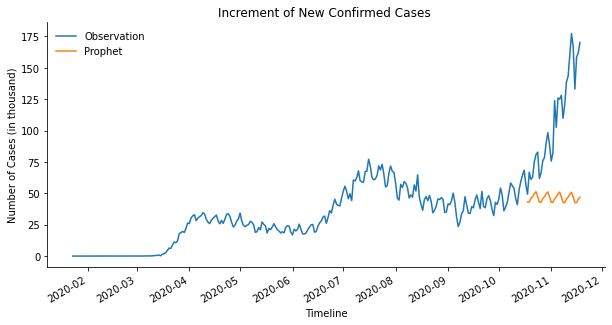

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data, label='Observation')
ax.plot(prophet_fit, label='Prophet')

ax.set_xlabel('Timeline')

ax.set_ylabel('Number of Cases (in thousand)')
ax.set_title('Increment of New Confirmed Cases ')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

fig.autofmt_xdate()
plt.savefig('Prophet Prediction.svg', bbox_inches = 'tight', transparent = False)


**Next, we switch to logistic model and include seasonality**

In [34]:
train['cap'] = data['confirm'].max()
n = Prophet(growth='logistic',
            weekly_seasonality=True,
            daily_seasonality='auto')
n.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
prediction_n = n.make_future_dataframe(periods=data.shape[0]-train.shape[0])
prediction_n['cap'] = data['confirm'].max()
prophet_prediction_n = n.predict(prediction_n)

In [36]:
prophet_prediction_n = prophet_prediction_n.set_index('ds')
prophet_fit_n = prophet_prediction_n.yhat.loc[prophet_prediction_n.index>=startdate]
print('Prophet MAE = ', mean_absolute_error(prophet_fit_n, test))
print('Prophet MSE = ', mean_squared_error(prophet_fit_n, test))
print('Prophet RMSE = ', m.sqrt(mean_squared_error(prophet_fit_n, test)))

Prophet MAE =  50.336370655465494
Prophet MSE =  3774.2044081194185
Prophet RMSE =  61.43455386115715


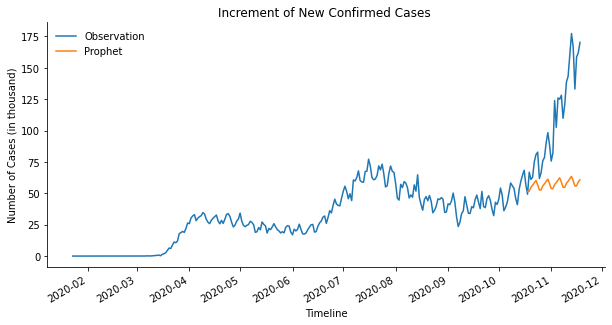

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data, label='Observation')
ax.plot(prophet_fit_n, label='Prophet')

ax.set_xlabel('Timeline')

ax.set_ylabel('Number of Cases (in thousand)')
ax.set_title('Increment of New Confirmed Cases ')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False)

fig.autofmt_xdate()

plt.savefig('Prophet Prediction with Logistic and Seasonality.svg', 
            bbox_inches = 'tight', transparent = False)

In [38]:
print('The max value of daily increase in new confirmed cases is {:.0f}.'.format(data.max()['confirm']))
print('The max value of predicted daily increase in new confirmed cases is {:.0f}.'.format(prophet_fit_n.max()))

The max value of daily increase in new confirmed cases is 177.
The max value of predicted daily increase in new confirmed cases is 63.


The Prophet Model fits better with weekly seasonality effect and logistic fitting model.

### Exact Forecast
Predict for 20 days.

In [39]:
data.reset_index(inplace=True)
data.rename(columns={'confirm':'y'}, inplace = True)
data['cap'] = data['y'].max()
n = Prophet(growth='logistic',
            weekly_seasonality=True,
            daily_seasonality='auto')
n.fit(data) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
forecast = n.make_future_dataframe(periods=20)
forecast['cap'] = data['y'].max()
prophet_forecast = n.predict(forecast)
enddate = '2020-11-19'
prophet_forecast.set_index('ds',inplace=True)
data.set_index('ds',inplace=True)
prophet_fit_forecast = prophet_forecast.yhat.loc[prophet_forecast.index>=enddate]

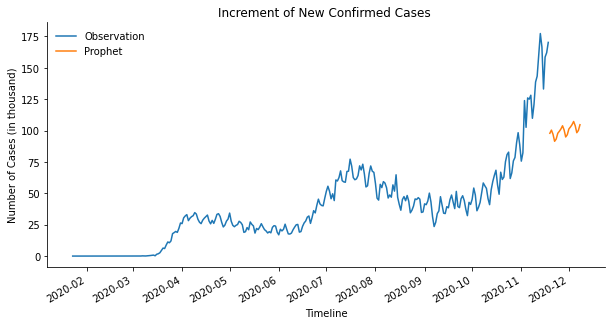

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data['y'], label='Observation')
ax.plot(prophet_fit_forecast, label='Prophet')

ax.set_xlabel('Timeline')
ax.set_ylabel('Number of Cases (in thousand)')
ax.set_title('Increment of New Confirmed Cases ')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False)

fig.autofmt_xdate()

plt.savefig('20-periods Forecast with Logistic and Seasonality.svg', 
            bbox_inches = 'tight', transparent = False)

In [42]:
print('The max value of daily increase in new confirmed cases is {:.0f}.'.format(data.max()['y']))
print('The max value of predicted daily increase in new confirmed cases is {:.0f}.'.format(prophet_fit_forecast.max()))

The max value of daily increase in new confirmed cases is 177.
The max value of predicted daily increase in new confirmed cases is 107.


### More: Transfer Daily Data into Weekly Data
To eliminate up and downs generated from missing data on weekend and variations according with test-centers' working hours.

In [43]:
# Create a new data set with all content that we need
data_new = pd.DataFrame(columns=['ds','confirm'])
date = list(dt.columns[11:])
date = list(pd.to_datetime(date))
# Check whether they have equal length
len(date) == len(d)
# Take a look at the data set
data_new['ds'] = date
data_new['confirm'] = d
data_new.set_index('ds',inplace=True)
data_new = data_new.resample('w').sum()
data_new['confirm']=data_new['confirm']/1000
data_new.head(5)

,confirm
ds,
2020-01-26,0.011
2020-02-02,0.046
2020-02-09,0.081
2020-02-16,0.094
2020-02-23,0.104


In [44]:
train = data_new.loc[data_new.index < pd.to_datetime(startdate)]
test  = data_new.loc[data_new.index >= pd.to_datetime(startdate)]

In [45]:
train['cap'] = data_new['confirm'].max()
l = Prophet(growth='logistic',
            weekly_seasonality='auto',
            daily_seasonality='auto')
train.reset_index(inplace=True)
train = train.rename(columns={'confirm':'y'})
l.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
prediction_l = l.make_future_dataframe(periods=data_new.shape[0]-train.shape[0],freq="w")
prediction_l['cap'] = data_new['confirm'].max()
prophet_prediction_l = l.predict(prediction_l)

In [47]:
prophet_prediction_l.set_index('ds',inplace=True)

In [48]:
prophet_prediction_l.loc[prophet_prediction_l.index>=startdate]

,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,
2020-10-18,56858.376827,74011.155,54956.308274,58769.660303,56858.376776,56858.376879,0.0,0.0,0.0,0.0,0.0,0.0,56858.376827
2020-10-25,58707.071832,74011.155,56835.872106,60529.240826,58707.071668,58707.071999,0.0,0.0,0.0,0.0,0.0,0.0,58707.071832
2020-11-01,60404.200762,74011.155,58476.305562,62235.341731,60404.200463,60404.201074,0.0,0.0,0.0,0.0,0.0,0.0,60404.200762
2020-11-08,61951.788026,74011.155,59978.258217,63797.954069,61951.787589,61951.788470,0.0,0.0,0.0,0.0,0.0,0.0,61951.788026
2020-11-15,63354.413636,74011.155,61466.649080,65228.573455,63354.413065,63354.414211,0.0,0.0,0.0,0.0,0.0,0.0,63354.413636
2020-11-22,64618.633390,74011.155,62711.976147,66498.362102,64618.632727,64618.634084,0.0,0.0,0.0,0.0,0.0,0.0,64618.633390


In [49]:
prophet_fit_l = prophet_prediction_l.yhat.loc[prophet_prediction_l.index>=startdate]
print('Prophet MAE = ', mean_absolute_error(prophet_fit_l, test))

Prophet MAE =  8367.04649337505


In [50]:
print('Prophet MSE = ', mean_squared_error(prophet_fit_l, test))

Prophet MSE =  180463355.35982963


In [51]:
print('Prophet RMSE = ',m.sqrt(mean_squared_error(prophet_fit_l, test)))

Prophet RMSE =  13433.665001027442


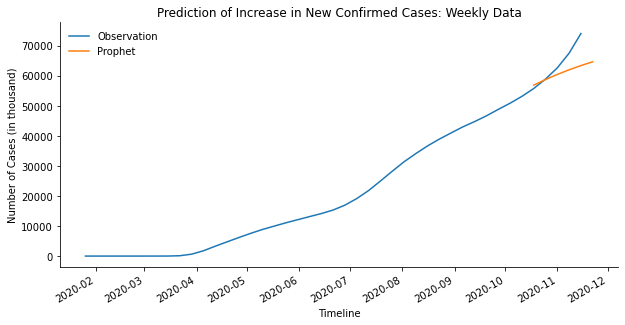

In [52]:
fig, ax3 = plt.subplots(figsize=(10,5))
ax3.plot(data_new[:-1], label='Observation')
ax3.plot(prophet_fit_l, label='Prophet')

ax3.set_xlabel('Timeline')
ax3.set_ylabel('Number of Cases (in thousand)')
ax3.set_title('Prediction of Increase in New Confirmed Cases: Weekly Data')

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax3.legend(frameon=False)

fig.autofmt_xdate()

plt.savefig('Weekly.svg', 
            bbox_inches = 'tight', transparent = False)

### Use Weekly Data to Implement ARMA

In [53]:
del train['cap']

In [54]:
train.set_index('ds',inplace=True)

In [55]:
model2 = pm.auto_arima(train, start_p=2, start_q=2,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=5, max_q=5,  # maximum p and q
                      m=1,               # frequency of series
                      d=None,            # automatically find 'd'
                      seasonal=False,    # Without Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model2.summary())
#(2,2,1)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=502.468, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=483.190, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=487.062, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=502.769, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=484.169, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=484.452, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=478.243, Time=0.23 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=486.295, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=485.043, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=482.230, Time=0.18 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0] intercept
Total fit time: 1.787 seconds
                               SARIMAX Results 

In [56]:
warnings.filterwarnings('ignore')
model2 = SARIMAX(train, order = (2,2,1))

In [57]:
result2 = model2.fit(disp=True)

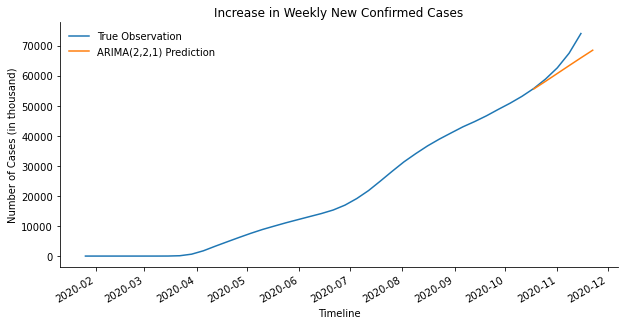

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
sarimax_pred = result2.predict(
    start = startdate, 
    end = '2020-11-18', 
    dynamic = False)
ax.plot(data_new[:-1], label = 'True Observation')
ax.plot(sarimax_pred, label = 'ARIMA(2,2,1) Prediction')

ax.set_xlabel('Timeline')
ax.set_ylabel('Number of Cases (in thousand)')
ax.set_title('Increase in Weekly New Confirmed Cases')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False)

fig.autofmt_xdate()

plt.savefig('SARIMAX prediction weekly.svg',bbox_inches = 'tight', transparent = False)

In [59]:
print('Prophet MAE = ', mean_absolute_error(sarimax_pred, test),'\n',
     'Prophet RMSE = ', m.sqrt(mean_squared_error(sarimax_pred, test)))

Prophet MAE =  8232.025103354514 
 Prophet RMSE =  14542.440743997813


In [60]:
mae = pd.DataFrame({'MODEL':['ARIMA(5,1,5)','Linear FB Prophet',
                             'Seasonal Adjusted Logistic FB Prophet',
                             'Logistic FB Prophet with Weekly Data',
                            'ARIMA(2,2,1) with Weekly Data'],
                    'MAE':[50.9260,61.2131,50.3364,8367.0465,8232.0251],
                   'RMSE':[62.6179,71.4905,61.4346,13433.6650,14542.4407]})

In [61]:
mae
#print(mae.to_latex(index=False))

,MODEL,MAE,RMSE
0,"ARIMA(5,1,5)",50.9260,62.6179
1,Linear FB Prophet,61.2131,71.4905
2,Seasonal Adjusted Logistic FB Prophet,50.3364,61.4346
3,Logistic FB Prophet with Weekly Data,8367.0465,13433.6650
4,"ARIMA(2,2,1) with Weekly Data",8232.0251,14542.4407


We can see from the table above: 
* the Seasonal Adjusted Logistic FB Prophet shows the best performance in prediction
* The MAE for the last two models with weekly data are not comparable to the first three
* For both daily and weekly data, Prophet model predict better than ARIMA

### ML Algorithm - XGBOOST

In [62]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [66]:
import numpy as np
from xgboost import XGBRegressor
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [67]:
data = pd.DataFrame(data['y'])
data.head()

,y
ds,
2020-01-23,0.000
2020-01-24,0.001
2020-01-25,0.000
2020-01-26,0.003
2020-01-27,0.000


In [68]:
# Model feature selection
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y

In [69]:
featurize(data)[1].head()

ds
2020-01-23    0.000
2020-01-24    0.001
2020-01-25    0.000
2020-01-26    0.003
2020-01-27    0.000
Name: y, dtype: float64

In [73]:
# split training set and test set according to selected features
X_train, y_train = featurize(
    data.loc[data.index < pd.to_datetime(startdate)])
X_test, y_test = featurize(
    data.loc[data.index >= pd.to_datetime(startdate)])

In [74]:
# Data preprocessing
scaler = StandardScaler()
scaler.fit(X_train)

scaler_train = scaler.transform(X_train)
scaler_test = scaler.transform(X_test)

In [82]:
# Train XGBOOST model
XGBOOST_model = XGBRegressor(n_estimators=10)
XGBOOST_model.fit(scaler_train, y_train,
                  eval_set=[(scaler_train, y_train), (scaler_test, y_test)],
                  verbose=True)
# Use XGBOOST model to make predictions
XGBOOST_prediction = XGBOOST_model.predict(scaler_test)
# Print evaluation criteria for XGBOOST model
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('XGBOOST RMSE = ', m.sqrt(mean_squared_error(XGBOOST_prediction, y_test)))

[0]	validation_0-rmse:25.87251	validation_1-rmse:101.46249
[1]	validation_0-rmse:18.67628	validation_1-rmse:90.83727
[2]	validation_0-rmse:13.57597	validation_1-rmse:85.03245
[3]	validation_0-rmse:10.00489	validation_1-rmse:79.60883
[4]	validation_0-rmse:7.46696	validation_1-rmse:75.29715
[5]	validation_0-rmse:5.62537	validation_1-rmse:72.67381
[6]	validation_0-rmse:4.31664	validation_1-rmse:69.69807
[7]	validation_0-rmse:3.37693	validation_1-rmse:67.46832
[8]	validation_0-rmse:2.71181	validation_1-rmse:66.02246
[9]	validation_0-rmse:2.23267	validation_1-rmse:64.74673
XGBOOST MAE =  54.043124460220355
XGBOOST RMSE =  64.74672883597121


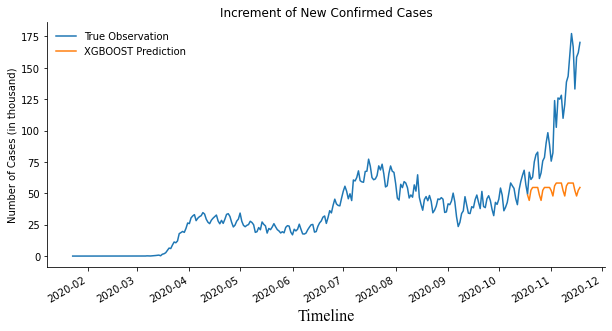

In [88]:
# The XGBOOST model predicted value is converted to DataFrame
# Test set index is mapped to the predicted value
XGBOOST_df = pd.DataFrame(XGBOOST_prediction)
XGBOOST_df.index = y_test.index

# the Visualization of predicted values and true values
fig, ax3 = plt.subplots(figsize=(10,5))
ax3.plot(data, label='True Observation')
ax3.plot(XGBOOST_df, label='XGBOOST Prediction')
ax3.legend(loc="upper left")
ax3.set_title('Increment of New Confirmed Cases')
ax3.set_ylabel('Number of Cases (in thousand)')
ax3.set_xlabel('Timeline', fontdict={'family': 'Times New Roman', 'size': 16})


ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax3.legend(frameon=False)

fig.autofmt_xdate()

plt.savefig('xgboost.svg',bbox_inches = 'tight', transparent = False)

### *Compare all MAE and RMSEs

In [84]:
mae = pd.DataFrame({'MODEL':['ARIMA(5,1,5)','Linear FB Prophet',
                             'Seasonal Adjusted Logistic FB Prophet',
                             'XGBOOST',
                             'ARIMA(2,2,1) with Weekly Data',
                             'Logistic FB Prophet with Weekly Data'],
                    'MAE':[50.9260,61.2131,50.3364,54.0431,8232.0251,8367.0465],
                   'RMSE':[62.6179,71.4905,61.4346,64.7467,14542.4407,13433.6650]})

In [85]:
mae

,MODEL,MAE,RMSE
0,"ARIMA(5,1,5)",50.9260,62.6179
1,Linear FB Prophet,61.2131,71.4905
2,Seasonal Adjusted Logistic FB Prophet,50.3364,61.4346
3,XGBOOST,54.0431,64.7467
4,"ARIMA(2,2,1) with Weekly Data",8232.0251,14542.4407
5,Logistic FB Prophet with Weekly Data,8367.0465,13433.6650


The table above compares MAEs and RMEs from all models used for this section. It suggest that Prophet with logistic model outperform others based on current split of training and testing set.

*Note: Please check part 2 for the exact forecast on future infection trend